# ROAD SEGMENTATION
## Experiments with different preprocessing techniques and learning models
In this notebook we are going to try to improve the accuracy and f1 score for the  road segmentation task,
using different methods. Firstly, let's start with a basic model using logistic regression.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.image as mpimg
import numpy as np
import os
from sklearn import linear_model
from sklearn.metrics import accuracy_score, f1_score
import sys
sys.path.append('../')
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Helper functions
def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

In [6]:
# Load images and ground truth
root_dir = "../data/training/"
image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = len(files)
imgs = [load_image(image_dir + files[i]) for i in range(n)]
gt_dir = root_dir + "groundtruth/"
print("Load " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]

Load 100 images


In [7]:
# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels
foreground_threshold = 0.25  # percentage of pixels > 1 required to assign a foreground label to a patch

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

In [8]:
# Extract 6-dimensional features consisting of average RGB color as well as variance
def extract_features(img):
    feat_m = np.mean(img, axis=(0,1))
    feat_v = np.var(img, axis=(0,1))
    feat = np.append(feat_m, feat_v)
    return feat

# Extract features for a given image
def extract_img_features(filename):
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, patch_size)
    X = np.asarray([ extract_features(img_patches[i]) for i in range(len(img_patches))])
    return X

# Compute features for each image patch
def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0

In [9]:
X = np.asarray([ extract_features(img_patches[i]) for i in range(len(img_patches))])
Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])
# Print feature statistics

print('Computed ' + str(X.shape[0]) + ' features (patches)')
print('Feature dimension = ' + str(X.shape[1]))
print('Number of classes = ' + str(np.max(Y)))

Computed 62500 features (patches)
Feature dimension = 6
Number of classes = 1


In [10]:
Y0 = [i for i, j in enumerate(Y) if j == 0]
Y1 = [i for i, j in enumerate(Y) if j == 1]
print('Class 0: ' + str(len(Y0)) + ' samples')
print('Class 1: ' + str(len(Y1)) + ' samples')

Class 0: 46309 samples
Class 1: 16191 samples


In [12]:
# train a logistic regression classifier

# we create an instance of the classifier and fit the data
logreg = linear_model.LogisticRegression(C=1e5, class_weight="balanced")
logreg.fit(X, Y)
# Predict on the training set
Z = logreg.predict(X)

# Get non-zeros in prediction and grountruth arrays
Zn = np.nonzero(Z)[0]
Yn = np.nonzero(Y)[0]

TPR = len(list(set(Yn) & set(Zn))) / float(len(Z))
accuracy = accuracy_score(Y, Z)
f1 = f1_score(Y, Z)
print('True positive rate = ' + str(TPR))
print('Accuracy score = ' + str(accuracy))
print('F1 score = ' + str(f1))



True positive rate = 0.17632
Accuracy score = 0.588288
F1 score = 0.4613581177258645


From the previous experiment we see that logistic regression performs quite poorly, even for a baseline. No
data preprocessing was performed except the following: firstly we divide the images into smaller parts (patches), then
from each patch we store the mean and variance for each  of the 3 RGB channels. Hence, each patch now is a feature of
dimension 6. On ground truth data we aggregate pixels into patches as well, labeling each patch to 0 or 1 if the
percentage of pixels greater than 1 is higher than a certain threshold. For this reason patch sizes and threshold are
the two key parameters but none of them can significantly change the results ( also changing the patch size to 1,
applying the logistic regression on every pixel, returns similar accuracy and f1 score).


Since neural networks have proved to work very well on classification problems, among the other applications, let's
switch to them to see if we can get a better performance.

Let' now test our code with baseline config, using UNet without any preprocessing.

In [3]:
from run import  main
config = {
        "seed": 23,
        "valid_size": 0.2,
        "data_path": "../data/",
        "clahe": False,
        "gamma_correction": False,
        "gamma": 1.1,
        "normalize_and_centre": False,
        "data_augmentation": False,
        "num_rotations": 0,
        "divide_in_patches": False,
        "patches_size": 80,
        "batch_size": 15,
        "backbone": 'UNet',
        "criterion": 'BCEWithLogitsLoss',
        "optimizer_learning_rate": 0.001,
        "early_stopping_treshold": 10,
        "early_stopping": False,
        "epochs": 50,
        "epochs_print_gap": 1,
        'foreground_threshold': 0.25,
        "device": 'cuda:2',
        "create_submission": False,
        "postprocessing": True,
        "save_model": False,
        "train": True,
        "plot": True,
        "whole_data": False
    }

Epoch 1: train loss 0.5823000073432922, valid loss 0.6622999906539917, patch accuracy 0.2242, patch f1  0.3662
Epoch 2: train loss 0.5121999979019165, valid loss 0.8295000195503235, patch accuracy 0.2242, patch f1  0.3662
Epoch 3: train loss 0.4675999879837036, valid loss 1.0703999996185303, patch accuracy 0.2242, patch f1  0.3662
Epoch 4: train loss 0.4246000051498413, valid loss 0.944100022315979, patch accuracy 0.283, patch f1  0.3847
Epoch 5: train loss 0.39169999957084656, valid loss 1.0748000144958496, patch accuracy 0.3294, patch f1  0.4004
Epoch 6: train loss 0.3644999861717224, valid loss 0.7631999850273132, patch accuracy 0.3699, patch f1  0.412
Epoch 7: train loss 0.33559998869895935, valid loss 0.824999988079071, patch accuracy 0.4879, patch f1  0.4585
Epoch 8: train loss 0.31450000405311584, valid loss 0.4706999957561493, patch accuracy 0.6096, patch f1  0.53
Epoch 9: train loss 0.2930999994277954, valid loss 0.3693999946117401, patch accuracy 0.6527, patch f1  0.5577
Epoc

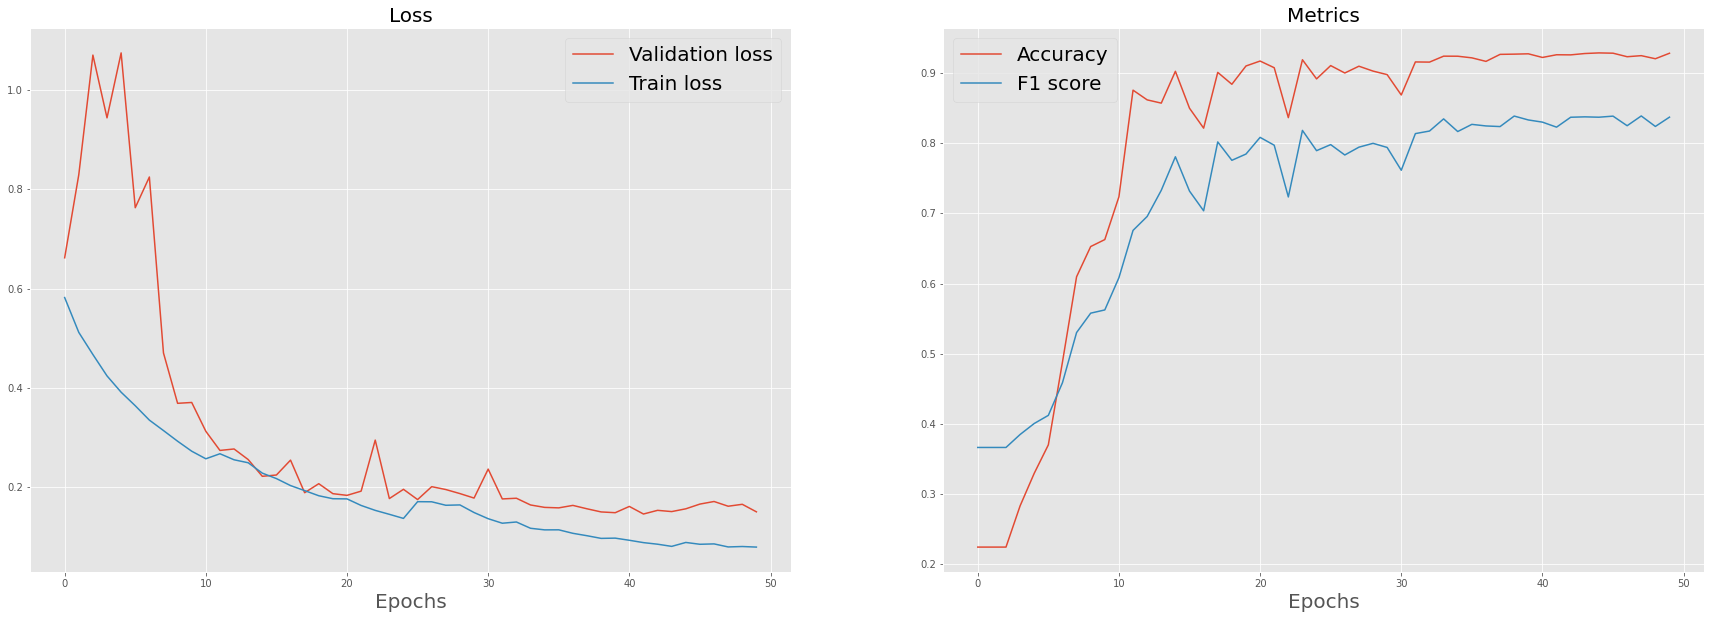

In [3]:
main(False, config = config)

We have only 80 images on training, so it seems to be not enough to train deep neural network as UNet. Therefore, we tried to extend the training data in two different ways:
 - divide each image into patches and train the model on them
 - augment data with flips and rotations

Let's now divide in patches of 80x80 pixel

Epoch 1: train loss 0.4277999997138977, valid loss 0.35989999771118164, patch accuracy 0.7199, patch f1  0.5811
Epoch 2: train loss 0.3458000123500824, valid loss 0.3921000063419342, patch accuracy 0.7667, patch f1  0.4806
Epoch 3: train loss 0.3231000006198883, valid loss 0.33230000734329224, patch accuracy 0.7518, patch f1  0.6329
Epoch 4: train loss 0.3009999990463257, valid loss 0.4171000123023987, patch accuracy 0.6894, patch f1  0.5828
Epoch 5: train loss 0.2791999876499176, valid loss 0.3012000024318695, patch accuracy 0.7635, patch f1  0.6353
Epoch 6: train loss 0.24879999458789825, valid loss 0.39500001072883606, patch accuracy 0.8166, patch f1  0.4792
Epoch 7: train loss 0.23739999532699585, valid loss 0.23440000414848328, patch accuracy 0.8121, patch f1  0.6879
Epoch 8: train loss 0.21480000019073486, valid loss 0.2142000049352646, patch accuracy 0.911, patch f1  0.7802
Epoch 9: train loss 0.19689999520778656, valid loss 0.18559999763965607, patch accuracy 0.9173, patch f1  

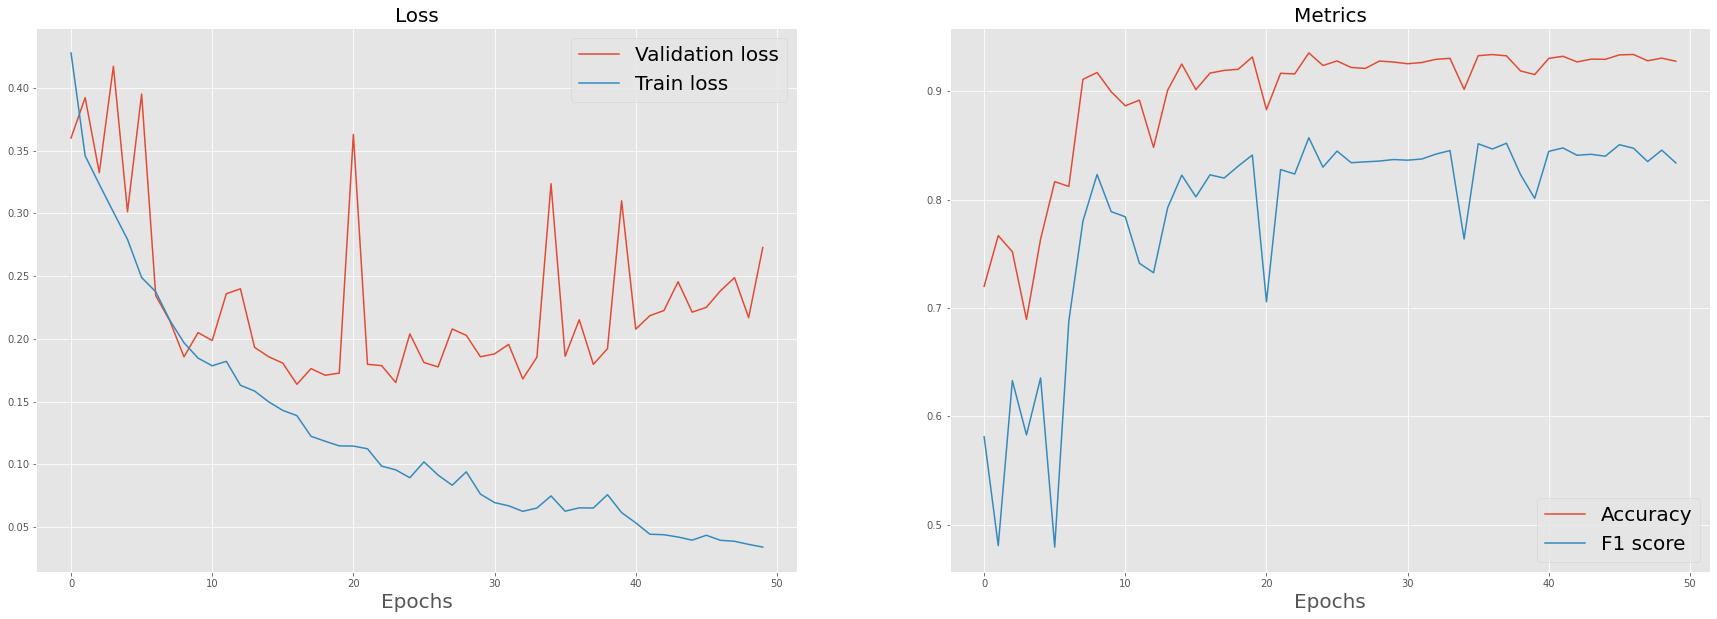

In [4]:
config["divide_in_patches"] = True
main(False, config= config)

Dividing into patches doesn't improve performance. This is because we trained our model with small patches of size 80 x 80 but we evaluated our model on  whole images.Neural networks learn how to recognise small patterns in the image. When we evaluate the net on our whole image  the network seems to expect the same size of the patches.

Now let's do data augmentation:

Epoch 1: train loss 0.47870001196861267, valid loss 0.49399998784065247, patch accuracy 0.5353, patch f1  0.4062
Epoch 2: train loss 0.3305000066757202, valid loss 0.5393000245094299, patch accuracy 0.6228, patch f1  0.5134
Epoch 3: train loss 0.2563000023365021, valid loss 0.23019999265670776, patch accuracy 0.849, patch f1  0.7289
Epoch 4: train loss 0.23420000076293945, valid loss 0.20600000023841858, patch accuracy 0.8984, patch f1  0.7801
Epoch 5: train loss 0.21629999577999115, valid loss 0.19580000638961792, patch accuracy 0.9044, patch f1  0.7918
Epoch 6: train loss 0.19740000367164612, valid loss 0.18639999628067017, patch accuracy 0.8982, patch f1  0.7987
Epoch 7: train loss 0.17430000007152557, valid loss 0.19449999928474426, patch accuracy 0.9058, patch f1  0.7767
Epoch 8: train loss 0.1565999984741211, valid loss 0.19370000064373016, patch accuracy 0.8898, patch f1  0.7934
Epoch 9: train loss 0.156700000166893, valid loss 0.16699999570846558, patch accuracy 0.9226, patch f

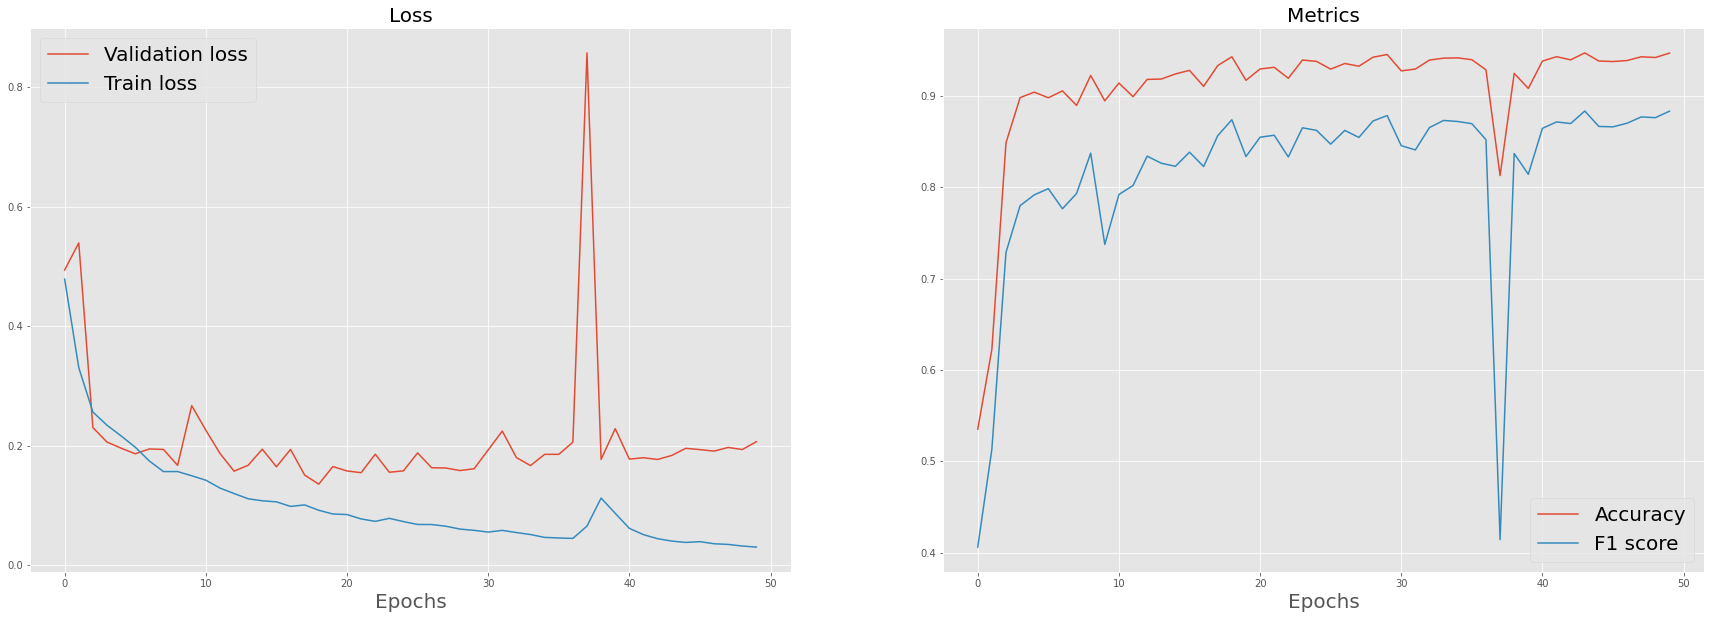

In [6]:
config["data_augmentation"] = True
config['num_rotations'] = 5
config["divide_in_patches"] = False
main(False, config= config)

According to the experiment above, we can see that the loss goes down faster, and we achieve a high f1 score faster.

Let's now experiment on different preprocessing techniques, CLAHE and gamma correction:

Epoch 1: train loss 0.47749999165534973, valid loss 0.8780999779701233, patch accuracy 0.2251, patch f1  0.3665
Epoch 2: train loss 0.3140999972820282, valid loss 0.27649998664855957, patch accuracy 0.8541, patch f1  0.7395
Epoch 3: train loss 0.24320000410079956, valid loss 0.23899999260902405, patch accuracy 0.8809, patch f1  0.7696
Epoch 4: train loss 0.2037000060081482, valid loss 0.19709999859333038, patch accuracy 0.9005, patch f1  0.8006
Epoch 5: train loss 0.17720000445842743, valid loss 0.1808999925851822, patch accuracy 0.9186, patch f1  0.8242
Epoch 6: train loss 0.16429999470710754, valid loss 0.18019999563694, patch accuracy 0.9096, patch f1  0.8201
Epoch 7: train loss 0.14429999887943268, valid loss 0.15950000286102295, patch accuracy 0.9286, patch f1  0.846
Epoch 8: train loss 0.13019999861717224, valid loss 0.18440000712871552, patch accuracy 0.8998, patch f1  0.805
Epoch 9: train loss 0.12839999794960022, valid loss 0.1906999945640564, patch accuracy 0.9058, patch f1  

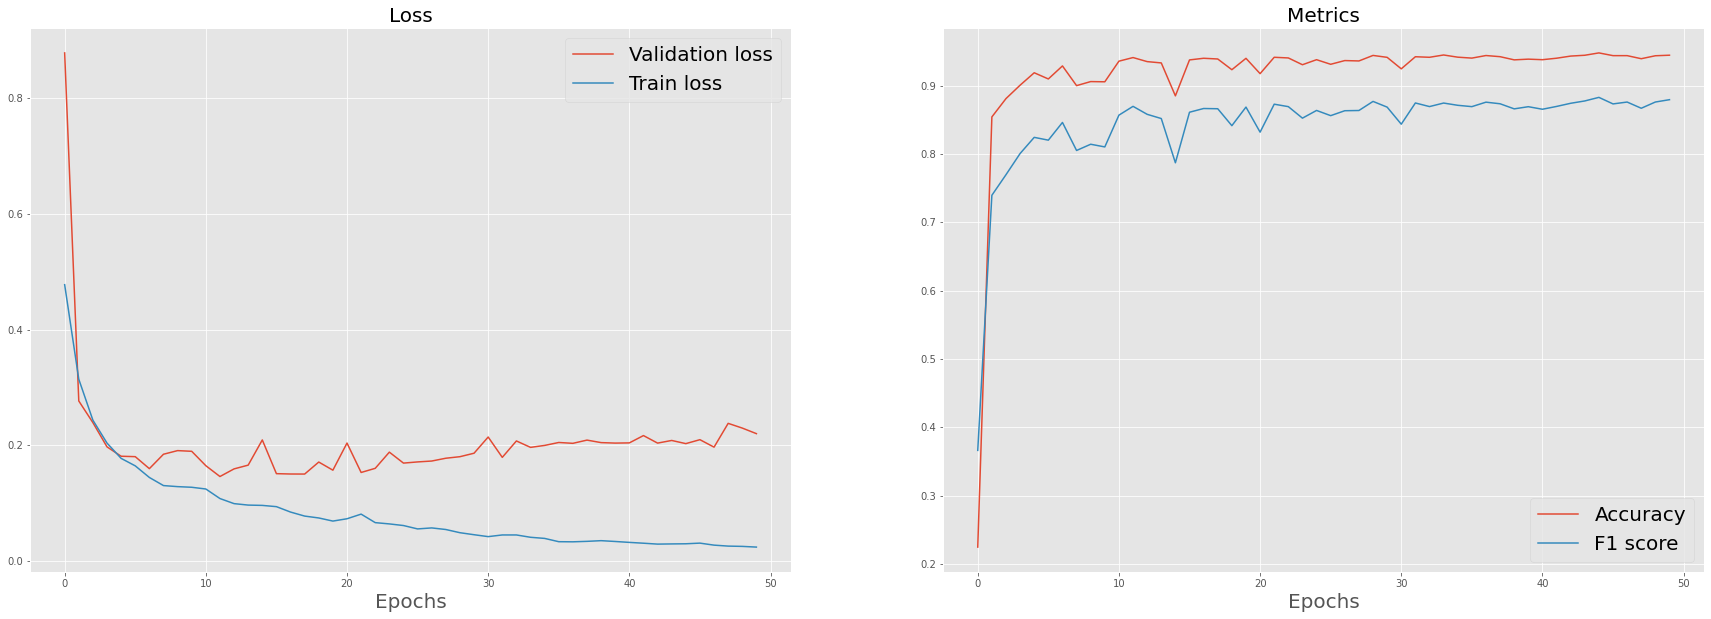

In [6]:
config["clahe"] = True
main(False, config= config)

Epoch 1: train loss 0.47870001196861267, valid loss 0.49399998784065247, patch accuracy 0.5353, patch f1  0.4062
Epoch 2: train loss 0.3305000066757202, valid loss 0.5393000245094299, patch accuracy 0.6228, patch f1  0.5134
Epoch 3: train loss 0.2563000023365021, valid loss 0.23019999265670776, patch accuracy 0.849, patch f1  0.7289
Epoch 4: train loss 0.23420000076293945, valid loss 0.20600000023841858, patch accuracy 0.8984, patch f1  0.7801
Epoch 5: train loss 0.21629999577999115, valid loss 0.19580000638961792, patch accuracy 0.9044, patch f1  0.7918
Epoch 6: train loss 0.19740000367164612, valid loss 0.18639999628067017, patch accuracy 0.8982, patch f1  0.7987
Epoch 7: train loss 0.17430000007152557, valid loss 0.19449999928474426, patch accuracy 0.9058, patch f1  0.7767
Epoch 8: train loss 0.1565999984741211, valid loss 0.19370000064373016, patch accuracy 0.8898, patch f1  0.7934
Epoch 9: train loss 0.156700000166893, valid loss 0.16699999570846558, patch accuracy 0.9226, patch f

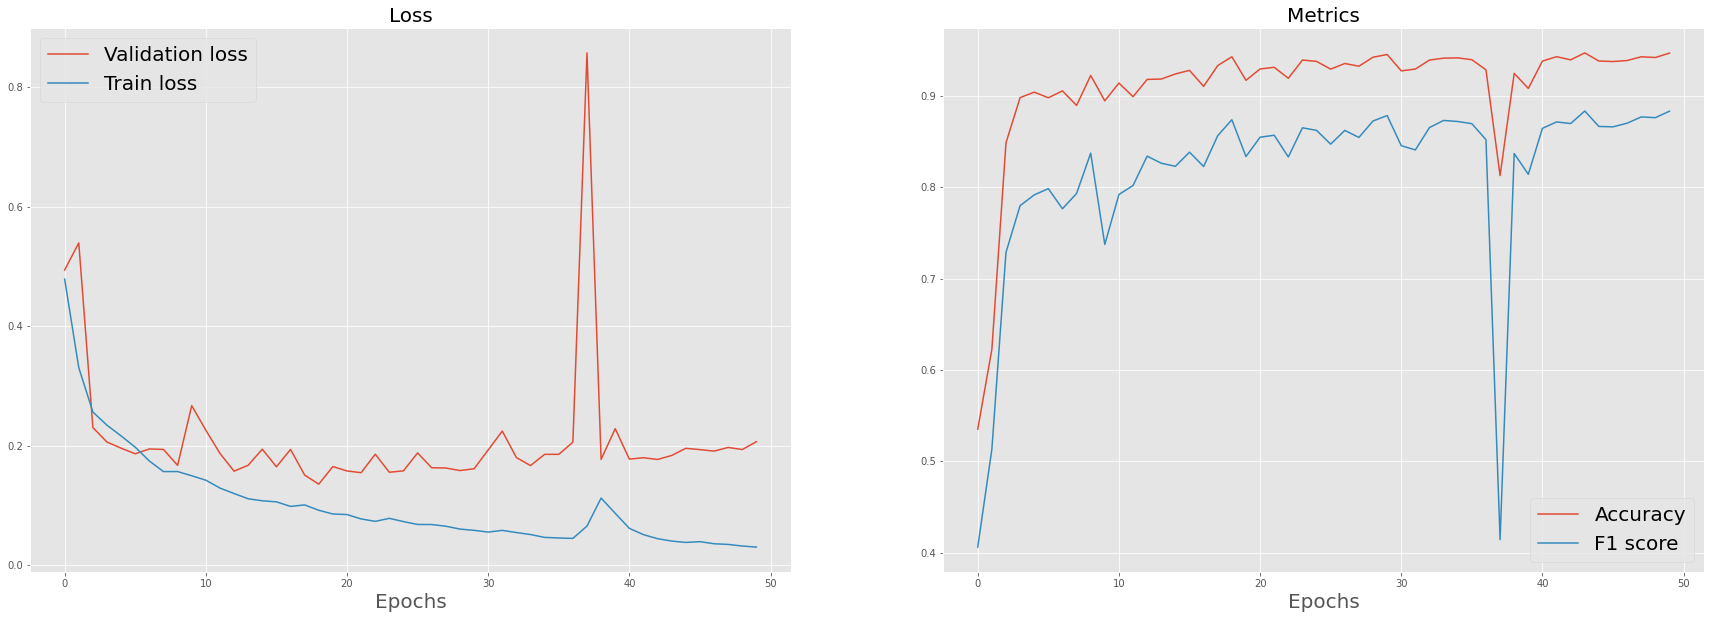

In [7]:
config["gamma_correction"]: True
config["clahe"] = False
main(False, config= config)

Epoch 1: train loss 0.47749999165534973, valid loss 0.8780999779701233, patch accuracy 0.2251, patch f1  0.3665
Epoch 2: train loss 0.3140999972820282, valid loss 0.27649998664855957, patch accuracy 0.8541, patch f1  0.7395
Epoch 3: train loss 0.24320000410079956, valid loss 0.23899999260902405, patch accuracy 0.8809, patch f1  0.7696
Epoch 4: train loss 0.2037000060081482, valid loss 0.19709999859333038, patch accuracy 0.9005, patch f1  0.8006
Epoch 5: train loss 0.17720000445842743, valid loss 0.1808999925851822, patch accuracy 0.9186, patch f1  0.8242
Epoch 6: train loss 0.16429999470710754, valid loss 0.18019999563694, patch accuracy 0.9096, patch f1  0.8201
Epoch 7: train loss 0.14429999887943268, valid loss 0.15950000286102295, patch accuracy 0.9286, patch f1  0.846
Epoch 8: train loss 0.13019999861717224, valid loss 0.18440000712871552, patch accuracy 0.8998, patch f1  0.805
Epoch 9: train loss 0.12839999794960022, valid loss 0.1906999945640564, patch accuracy 0.9058, patch f1  

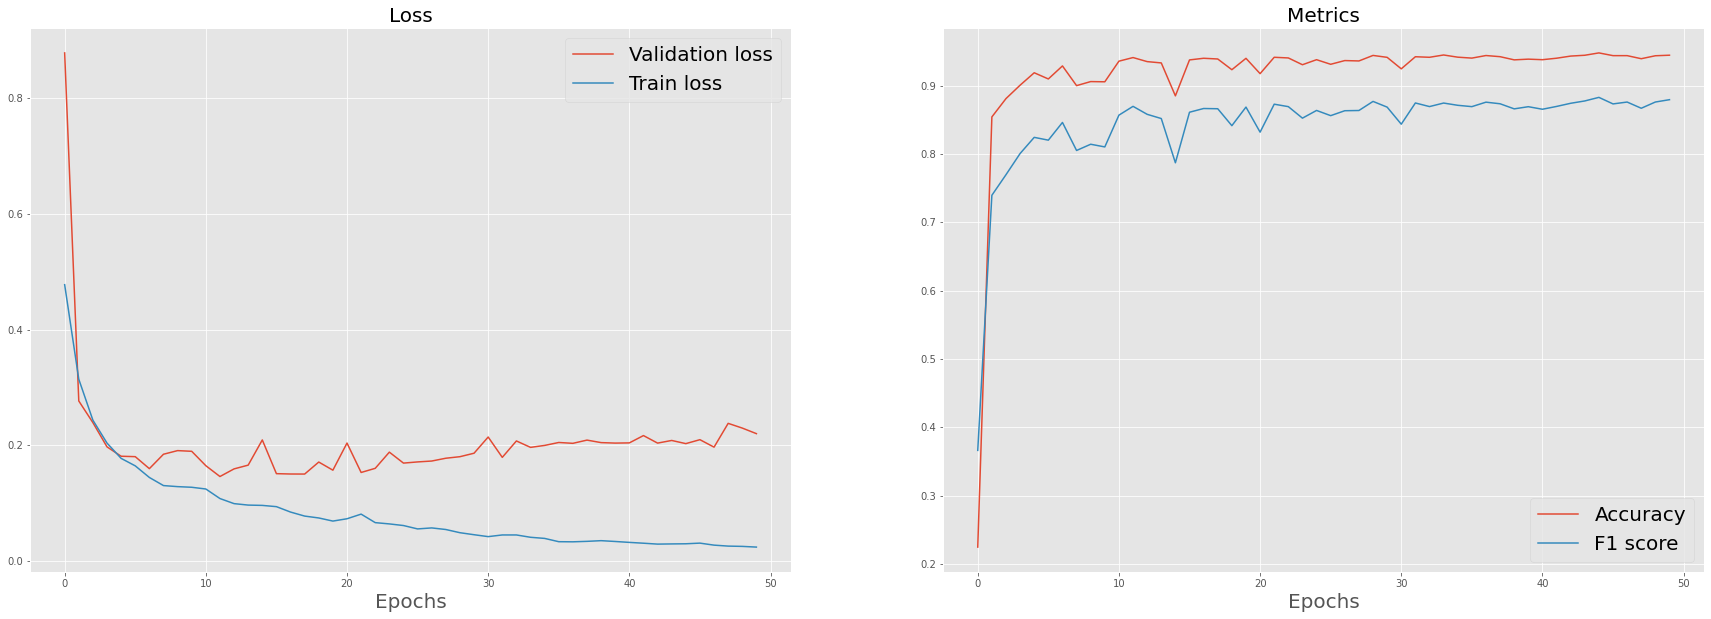

In [8]:
config["gamma_correction"]: True
config["clahe"] = True
main(False, config= config)

Epoch 1: train loss 0.42739999294281006, valid loss 0.6628000140190125, patch accuracy 0.7006, patch f1  0.5872
Epoch 2: train loss 0.26739999651908875, valid loss 0.32910001277923584, patch accuracy 0.7826, patch f1  0.6478
Epoch 3: train loss 0.21480000019073486, valid loss 0.3598000109195709, patch accuracy 0.8118, patch f1  0.6872
Epoch 4: train loss 0.19200000166893005, valid loss 0.23190000653266907, patch accuracy 0.8853, patch f1  0.7699
Epoch 5: train loss 0.17190000414848328, valid loss 0.27709999680519104, patch accuracy 0.8497, patch f1  0.7314
Epoch 6: train loss 0.15919999778270721, valid loss 0.2125999927520752, patch accuracy 0.9092, patch f1  0.8039
Epoch 7: train loss 0.14079999923706055, valid loss 0.19949999451637268, patch accuracy 0.9009, patch f1  0.7942
Epoch 8: train loss 0.13169999420642853, valid loss 0.21130000054836273, patch accuracy 0.9102, patch f1  0.8006
Epoch 9: train loss 0.12439999729394913, valid loss 0.20649999380111694, patch accuracy 0.9028, pat

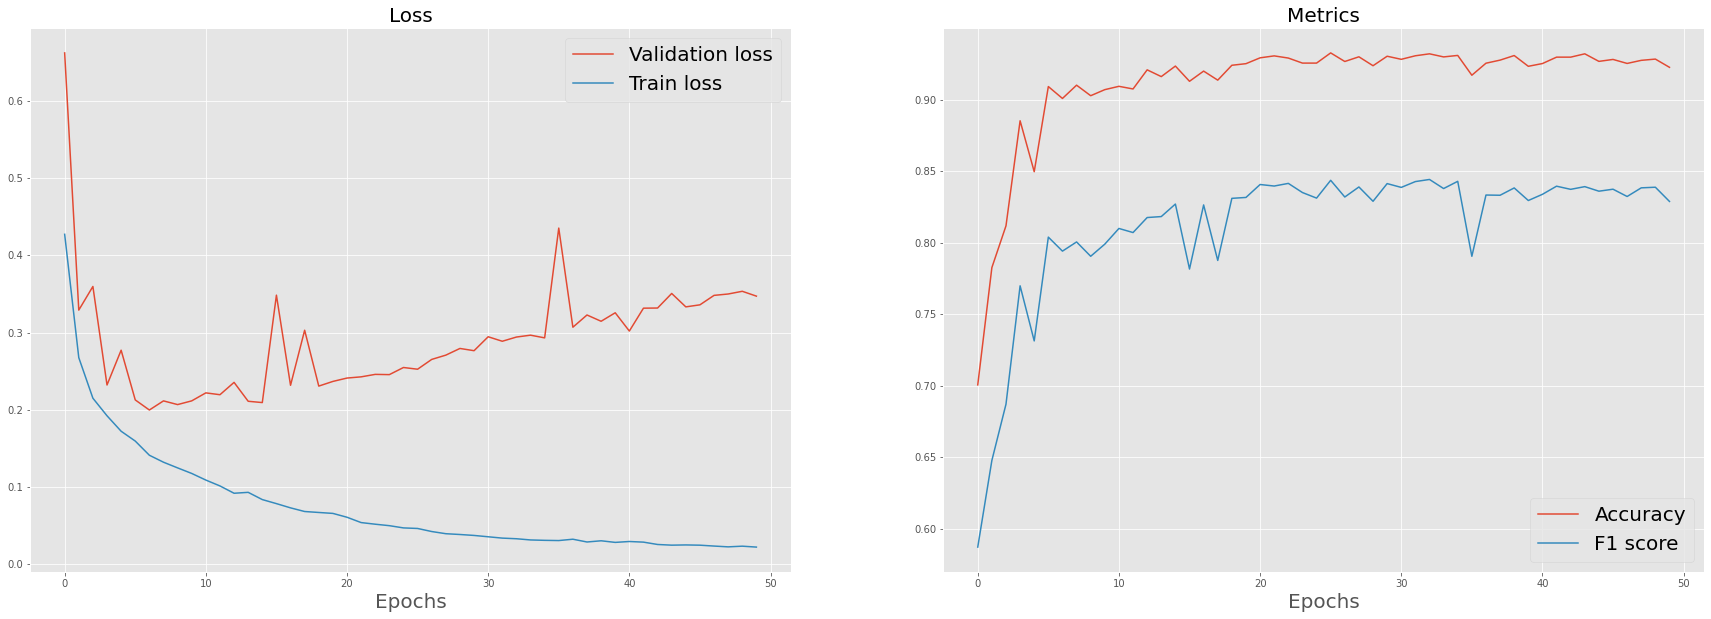

In [4]:
config["gamma_correction"] = False
config["clahe"] = False
config["data_augmentation"] = True 
config['num_rotations'] = 5 
config['normalize_and_centre'] = True
main(False, config= config)

As we can see, standardization doesn't improve performance, but it actually decreases it.

According to the above experiment, we could see that valid loss starts to increase while f1 score and accuracy go up as well. This happens because BCELoss is sensitive to unbalanced dataset (our dataset in unbalanced since there are a lot of background pixels). Let's try Dice Loss:

In [5]:
config["gamma_correction"] = False
config["clahe"] = False
config['normalize_and_centre'] = False

In [6]:
config["criterion"] = 'DiceLoss'

We use pretrained neural network,so ,in order not to change the pretrained weights 'rapidly', we put the lr equal to 0.0001 (10 times less than for not pretrained).

Epoch 1: train loss 0.3314000070095062, valid loss 0.3215000033378601, patch accuracy 0.893, patch f1  0.7838
Epoch 2: train loss 0.19009999930858612, valid loss 0.21739999949932098, patch accuracy 0.9436, patch f1  0.8703
Epoch 3: train loss 0.13230000436306, valid loss 0.19050000607967377, patch accuracy 0.9423, patch f1  0.8793
Epoch 4: train loss 0.11569999903440475, valid loss 0.1818999946117401, patch accuracy 0.9495, patch f1  0.8865
Epoch 5: train loss 0.11180000007152557, valid loss 0.15870000422000885, patch accuracy 0.9554, patch f1  0.9008
Epoch 6: train loss 0.09520000219345093, valid loss 0.16760000586509705, patch accuracy 0.9485, patch f1  0.8884
Epoch 7: train loss 0.08889999985694885, valid loss 0.16179999709129333, patch accuracy 0.951, patch f1  0.8897
Epoch 8: train loss 0.0786999985575676, valid loss 0.17139999568462372, patch accuracy 0.9507, patch f1  0.8927
Epoch 9: train loss 0.0722000002861023, valid loss 0.164900004863739, patch accuracy 0.9518, patch f1  0.

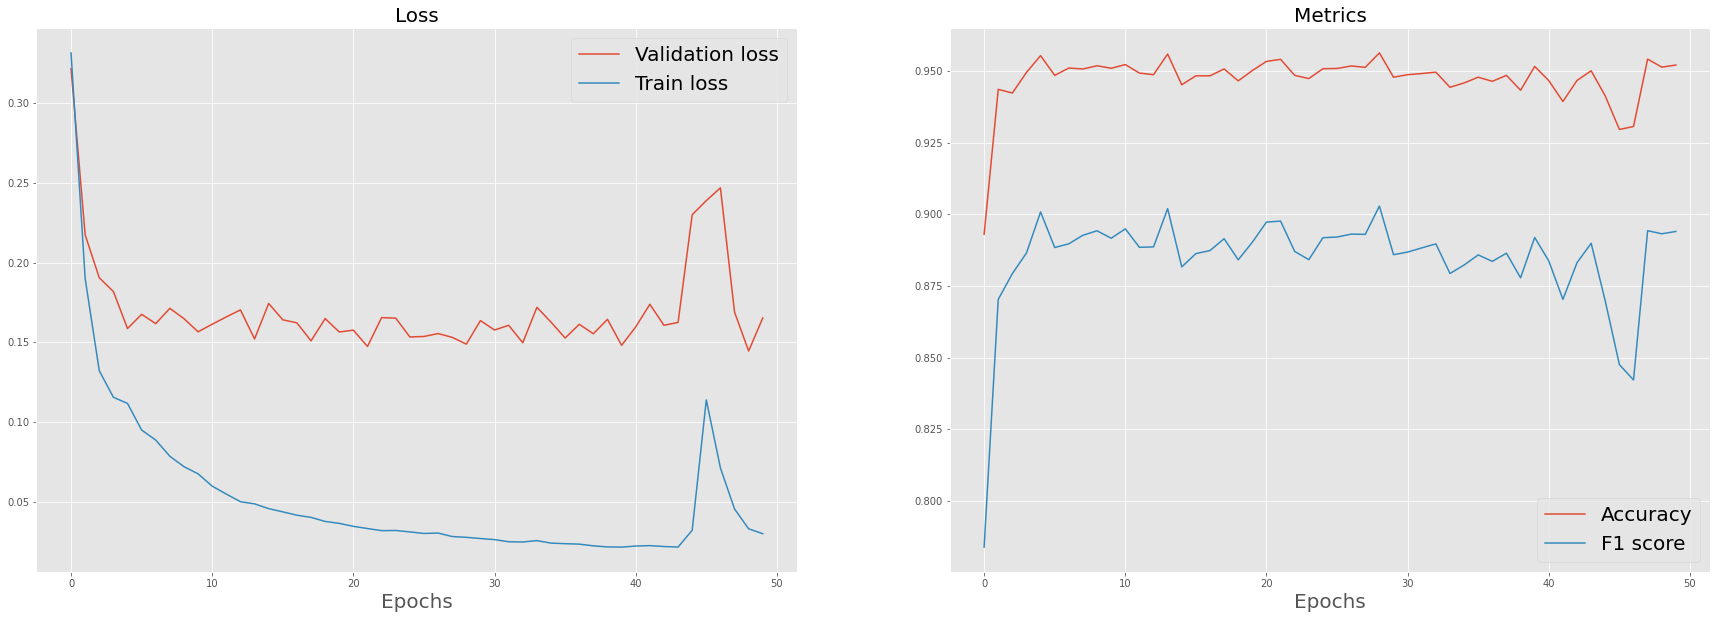

In [7]:
config["backbone"] = 'DeepLab'
main(False, config= config)

Epoch 1: train loss 0.3393000066280365, valid loss 0.3346000015735626, patch accuracy 0.8683, patch f1  0.7641
Epoch 2: train loss 0.16990000009536743, valid loss 0.2565999925136566, patch accuracy 0.9342, patch f1  0.8434
Epoch 3: train loss 0.14659999310970306, valid loss 0.22709999978542328, patch accuracy 0.9175, patch f1  0.8346
Epoch 4: train loss 0.1306000053882599, valid loss 0.17910000681877136, patch accuracy 0.9461, patch f1  0.88
Epoch 5: train loss 0.10970000177621841, valid loss 0.18359999358654022, patch accuracy 0.9498, patch f1  0.8882
Epoch 6: train loss 0.1023000031709671, valid loss 0.18359999358654022, patch accuracy 0.9447, patch f1  0.8811
Epoch 7: train loss 0.09470000118017197, valid loss 0.18690000474452972, patch accuracy 0.949, patch f1  0.8887
Epoch 8: train loss 0.08640000224113464, valid loss 0.1793999969959259, patch accuracy 0.9495, patch f1  0.8907
Epoch 9: train loss 0.07890000194311142, valid loss 0.18140000104904175, patch accuracy 0.9449, patch f1 

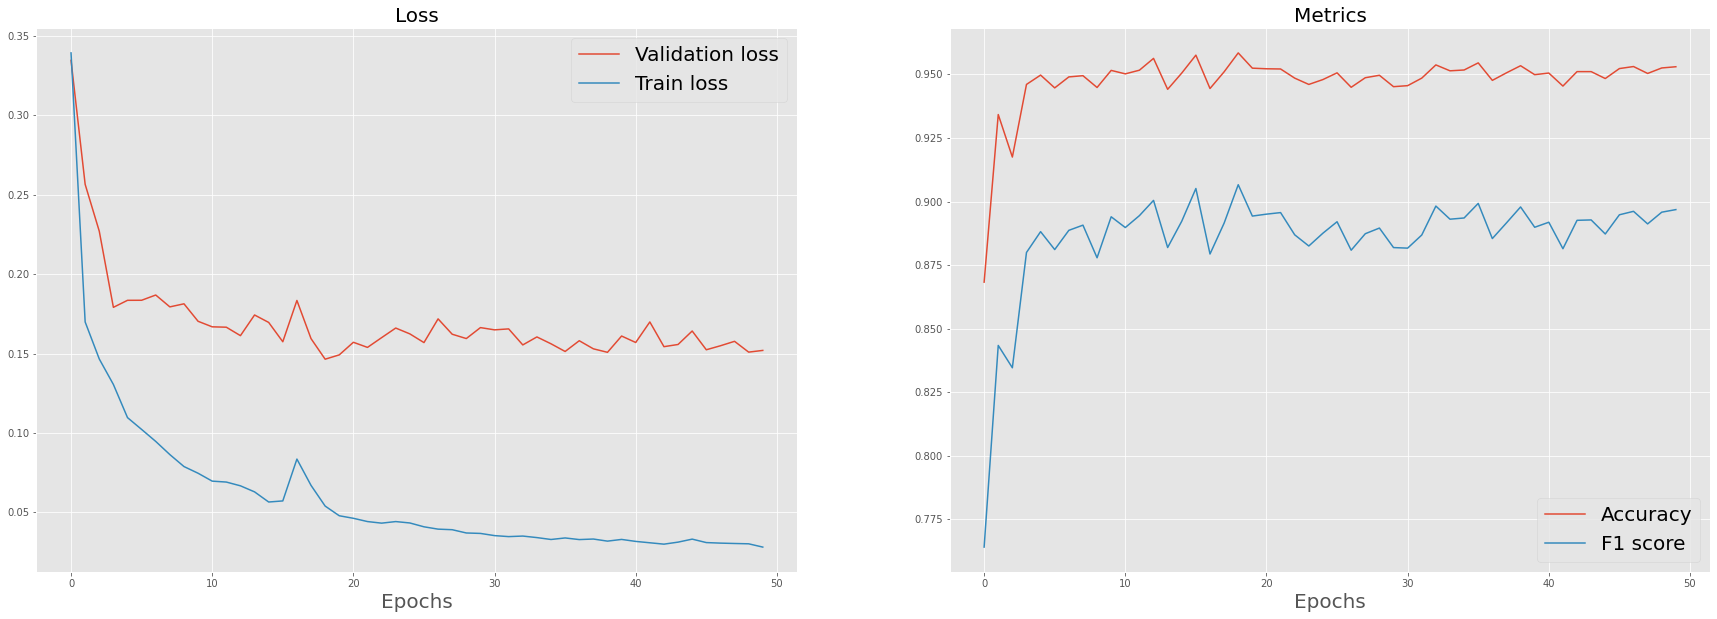

In [8]:
config["backbone"] = 'DeepLabPlus'
main(False, config = config)